# Audio to Audio Neural Networks with the Fastai Library

## If you're a fan of neural networks, you may have come across certain works like Google's "Look to Listen", or it's DeepMind WaveNet. It is very impressive to see an artificial intelligence that can understand what someone is saying, read text in a human-like voice or generate music based on certain parameters. With the current boom in NLP and image processing using neural networks (NN), this is a great time to start learning how to make NN's that recieves or outputs audio. This is because, as we will see later, audio processing benefits greatly from both NLP and image processing.

If you have ever tried to get into audio processing you may have noticed that there are a large amount of subjects you would need to study to make your first neural net. The goal of this blog is to give you a general idea of how you can make a Neural Network in pytorch using the fastai library so that you can generate a nice audio output. We will not be looking details about the structure of the NN except for how to input an output audio data into the model.

To make this easier I'll make a Neural Network that we will use to clean artificial noise from audios. This is a simple NN that has audio as input and as output, exactly what we need for this tutorial.

# Getting the Data
The first step we should always do is download our dataset, I found this one to be the simplest one to start with.
This dataset comes from Google and was used in training the LookToListen Algorithm. Thanks to Mayur Newase for sharing this dataset in Kaggle.

You can download the dataset from Kaggle here https://www.kaggle.com/mayurnewase/audio-dataset/downloads/audio-dataset.zip/1

# Importing libraries and defining varaibles

This line lets up easily see images made in matplotlib as they are made. This helps us view the results and should always be put a the beginning of a Jupyter Project

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

We import all of the necesary libraries, if there is one that you don't have installed just add it in your pip or conda env.

In [2]:
import os
import random
import numpy as np
from pathlib import Path
from shutil import copyfile

import fastai as meta_fai
import fastai.vision as fv
import fastai.basics as fai
import fastai.fastai_audio as fa

import librosa
import librosa.display

import matplotlib.pyplot as plt
import matplotlib

from IPython.display import Audio
from tqdm import tqdm

These are the paths to the dataset, I renamed mine to be called "Clean" but you can leave it as is if you want. Here we also define the Folder where we will store the audios with noise.

In [3]:
path_good   = Path("Clean")
path_crappy = Path("Noise")
path_good_normalized   = Path("Clean_norm")
path_crappy_normalized = Path("Noise_norm")

# "Crappify" Functions

This project follows the idea behind "crappify". This is esencially to take data that is of "good" quality (good resolution, has color, etc.) but is easy to transform into "bad" quality (lower resolution, gray-scale, etc.). This way we can make make our dataset starting from clean data and teaching the neural network to take the bad data and transform it to the good data.

In this case we will take audios and add noise to it, hoping that the NN can learn how to remove this type of noise.

### These functions makes random noise and adds it to the audios, you can play with the type of noise to best fit the noise that you have in real life. In this case we make our noise from a normal distribution. We add a multiplier to make sure that the noise doesn't completely shadow the original audio.

In [4]:
def crappy_name(good_name):
    good_name = good_name.relative_to(path_good)
    crappy_file = path_crappy/good_name
    crappy_file.parent.mkdir(parents=True, exist_ok=True)
    return crappy_file

def crappify(file, multiplier):
    crappy_file = crappy_name(file)
    
    clip, sample_rate = librosa.load(file, sr=None)
    
    noise = np.random.uniform(0, 1, clip.shape)
    noise*= multiplier
    noise+= clip

    librosa.output.write_wav(crappy_file, noise, sample_rate, True)

We apply these functions on everyfile in our Dataset to create the "crappy" dataset.

In [5]:
clean_files = os.listdir(path_good)

In [6]:
if not(path_crappy.exists()):
    path_crappy.mkdir(parents=True, exist_ok=True)
    multiplier = 0.03
    for file in tqdm(clean_files):
        crappify(path_good/Path(file), multiplier)

In [7]:
noisy_files = os.listdir(path_crappy)

---------------------------------------------

# Audio to images

In the study of audio, it is pretty much accepted that the best way to work with these datasets is to transform the noise into an image. We will explain how this project works later, but for now just understand that there is a very clever mathmatical method on how to do this called Short Time Fourier Transforms (STFT), which is what we will be using.

Quick Note: There are exceptions, for example Google WaveNet uses raw sequential audio, but for most tasks you will get better results using STFT.

The first function simply makes the name where we will be storing these images, in this case it will be in a new folder with "_image" at the end of the name. It stores it with the extension ".np" which is just one we made up for this activity.

The second function loads the audio and makes the Matrix from the stft function librosa has. After that we save the Matrix in its appropriate file name using the torch save function. In the commented line you can see an example of how to undo the STFT function, which is just Inverse STFT (or ISTFT)

# STFT Function

Explaination of how the functions works

# Viewing an example

So one of the problems you might find in this method is that the variables will change depending on the "resolution" of the image when we decide to inverse the process. And you are right, but in practice it won't really affect much as the parameters we are using are very conservatives. Lets see how the data looks like.

We add one more function which allows us to view the Spectrogram of a certain file in different subplots. At the same time we create our imageset for all files in the clean and noisy folders.

In [8]:
def plot_matrix(filepath:Path, n_fft:int = 1024, start:int = 0, n_mels:int = 64, fmin:int = 20, fmax:int = 8000, ax=None):
    clip, sample_rate = librosa.load(filepath)
    
    x = clip[start:start+n_fft]
    X = librosa.audio.fft.fft(x, n_fft)
    X_magnitude, X_phase = librosa.magphase(X)
    X_magnitude_db = librosa.amplitude_to_db(X_magnitude)
    
    hop_length = n_fft//2 + 1
    stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, stft_phase = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    
    mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, sr=sample_rate, power=1.0, fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    
    librosa.display.specshow(mel_spec_db, ax=ax)
    plt.plot()

Now we just use this function to plot a few clean and noisy audios.

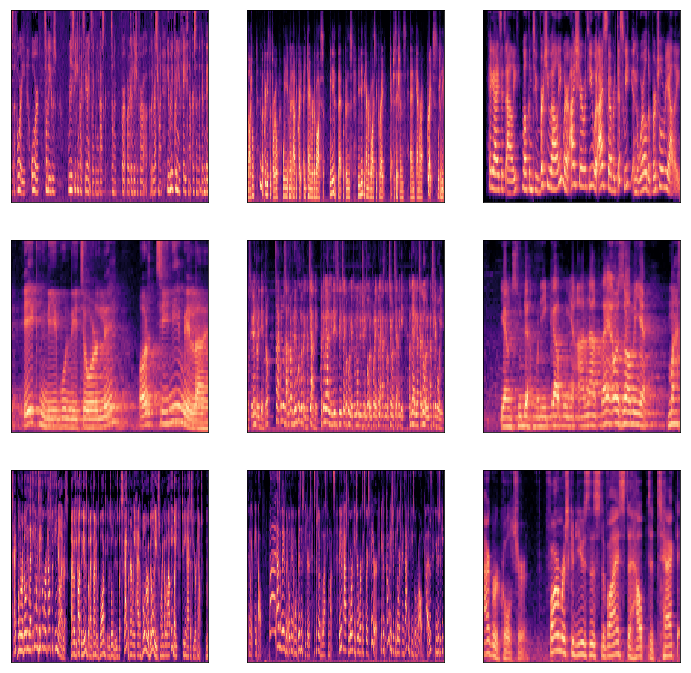

In [9]:
rows = 3
cols = 3
axs = fai.subplots(rows, cols)
for i, file in enumerate(clean_files[:rows*cols]):
    plot_matrix(path_good/Path(file), ax=axs[i//rows][i%rows])

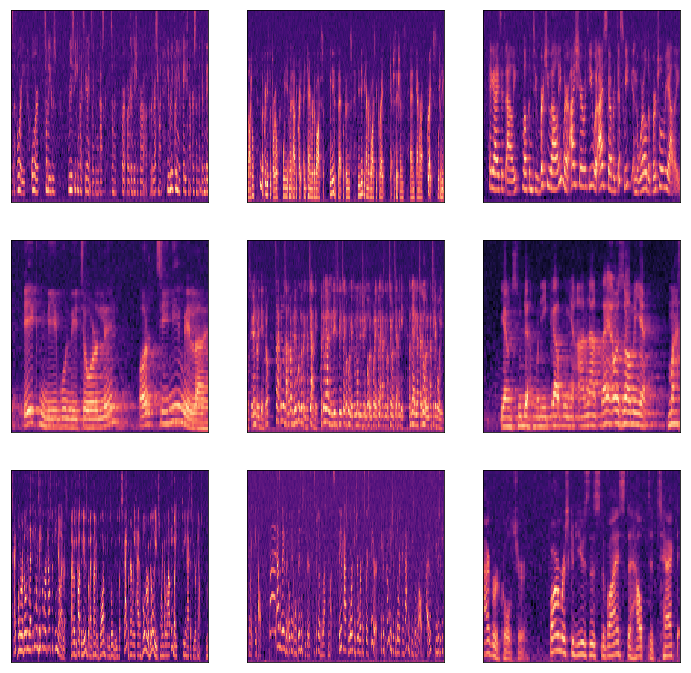

In [10]:
rows = 3
cols = 3
axs = fai.subplots(rows, cols)
for i, file in enumerate(noisy_files[:rows*cols]):
    plot_matrix(path_crappy/Path(file), ax=axs[i//rows][i%rows])

# Comparing Clean Images vs Noisy Images

If we look at the two images we can't really see much, but with enough attention we will notice that there are changes in the image. This is what we will be trying remove in our next steps. To make the comparisons easier lets plot a clean and noisy audio together. As you can see there are slight differences between the two, which is easier to see in the borders of orange marks.

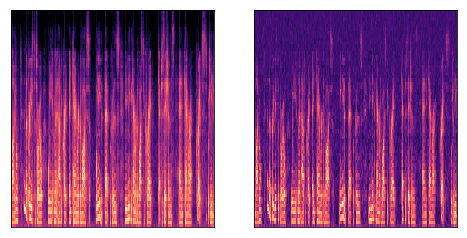

In [11]:
axs = fai.subplots(1, 2)
file1 = clean_files[1]
file2 = noisy_files[1]

plot_matrix(path_good/Path(file1), ax=axs[0][0])
plot_matrix(path_crappy/Path(file2), ax=axs[0][1])

# Normalizing the Data

Now this could look good at first, but we are still missing one very important part in our preprocessing, which is normalization. To do this librosa has a function that lets us normalize the audio in one line

In [12]:
def norm_name(good_name):
    good_name = good_name.relative_to(path_good)
    norm_file = path_good_normalized/good_name
    norm_file.parent.mkdir(parents=True, exist_ok=True)
    return norm_file

def norm_clean(file):
    norm_file = norm_name(file)
    clip, sample_rate = librosa.load(file, sr=None)
    
    clip = librosa.util.normalize(clip)

    librosa.output.write_wav(norm_file, clip, sample_rate, True)

In [13]:
if not(path_good_normalized.exists()):
    path_good_normalized.mkdir(parents=True, exist_ok=True)
    for file in tqdm(clean_files[:3]):
        norm_clean(path_good/Path(file))

def norm_name(good_name):
    good_name = good_name.relative_to(path_crappy)
    norm_file = path_crappy_normalized/good_name
    norm_file.parent.mkdir(parents=True, exist_ok=True)
    return norm_file

def norm_crappy(file):
    norm_file = norm_name(file)
    clip, sample_rate = librosa.load(file, sr=None)
    
    clip = librosa.util.normalize(clip)

    librosa.output.write_wav(norm_file, clip, sample_rate, True)

if not(path_crappy_normalized.exists()):
    path_crappy_normalized.mkdir(parents=True, exist_ok=True)
    for file in tqdm(noisy_files):
        norm_clean(path_crappy/Path(file))

In [14]:
def crappy_name(good_name):
    good_name = good_name.relative_to(path_good_normalized)
    crappy_file = path_crappy_normalized/good_name
    crappy_file.parent.mkdir(parents=True, exist_ok=True)
    return crappy_file

def crappify(file, multiplier):
    crappy_file = crappy_name(file)
    
    clip, sample_rate = librosa.load(file, sr=None)
    
    noise = np.random.uniform(0, 1, clip.shape)
    noise*= multiplier
    noise+= clip

    librosa.output.write_wav(crappy_file, noise, sample_rate, True)

In [15]:
clean_normalized_files = os.listdir(path_good_normalized)

In [16]:
if not(path_crappy_normalized.exists()):
    path_crappy_normalized.mkdir(parents=True, exist_ok=True)
    multiplier = 0.03
    for file in tqdm(clean_normalized_files):
        crappify(path_good_normalized/Path(file), multiplier)

100%|██████████| 1071/1071 [04:50<00:00,  4.09it/s]
